# Production System Assignment

## Production System with PSP and RL agent optimization

In [99]:
from __future__ import annotations

import random
import statistics
from collections.abc import Callable
import numpy as np
import simpy
from scipy import stats
from simpy.events import ProcessGenerator
from lib.server import Server
from lib.job import Job
from matplotlib import pyplot as plt
from lib.config import SEEDS
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize
import os
import copy

In [2]:
NUM_MACHINES = 6

In [18]:
MIN_THROUGHPUT_INTERVAL = 0.0
MAX_THROUGHPUT_INTERVAL = 1.0
MIN_TARDINESS_INTERVAL = 0.0
MAX_TARDINESS_INTERVAL = 1.0
MIN_EARLINESS_INTERVAL = 0.0
MAX_EARLINESS_INTERVAL = 1.0
MIN_WIP_WORK_CONTENT_INTERVAL = 0.0
MAX_WIP_WORK_CONTENT_INTERVAL = 1.0

In [23]:
class SystemEnv(gym.Env):
    def __init__(
        self,
        inter_arrival_time_distribution: Callable[[], float],
        processing_time_per_family_distribution: list[Callable[[], float]],
        families_distribution: Callable[[], float],
        due_dates_distribution: Callable[[], float],
        routing_distribution: dict[int, list[Callable[[], float]]],
        routing_prob: dict[int, list[float]],
        agent_decision_interval: float = 3.0, # 10, 5
        episode_duration: float = 60 * 160,
        reward_weights: dict[str, float] = None
    ) -> None:
        super().__init__()
        self.env: simpy.Environment | None = None
        self.inter_arrival_time_distribution = inter_arrival_time_distribution
        self.processing_time_per_family_distribution = processing_time_per_family_distribution
        self.families_distribution = families_distribution
        self.due_dates_distribution = due_dates_distribution
        self.routing_distribution = routing_distribution
        self.routing_prob = routing_prob
        self.agent_decision_interval = agent_decision_interval
        self.episode_duration = episode_duration

        self.e  = 0
        self.reward_weights = reward_weights if reward_weights is not None else {
            'throughput': 1.0,
            'wip_penalty': -1.0,
            'tardiness_penalty': -1.0,
            'earliness_penalty': -1.0
        }

        low_bounds = np.array([
            0.0,
            0.0,
            -5000.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0
        ], dtype=np.float32)

        high_bounds = np.array([
            1.0,
            500.0,
            5000.0,
            10000.0,
            10000.0,
            10000.0,
            10000.0,
            10000.0,
            10000.0
        ], dtype=np.float32)

        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

        # action space: 0 = Don't Release, 1 = Release
        self.action_space = spaces.Discrete(2)

        self.machines: list[Server] = []
        self.jobs: list[Job] = []
        self.pre_shop_pool: list[Job] = []
        self.idx_counter = 0

        self.jobs_completed_in_current_interval: list[Job] = []

        self.last_wip_value = 0.0
        self.last_wip_time = 0.0
        self.cumulative_wip_area = 0.0
        self.current_interval_wip_area = 0.0

        self.next_scheduled_arrival_time = float('inf')

        self.calibration_throughput_intervals: list[float] = []
        self.calibration_tardiness_intervals: list[float] = []
        self.calibration_earliness_intervals: list[float] = []
        self.calibration_avg_wip_intervals: list[float] = []

        self.calibration_obs_job_top_proc_time: list[float] = []
        self.calibration_obs_job_top_urgency: list[float] = []
        self.calibration_obs_machine_workloads_flat: list[float] = []

    def compute_wip_for_servers(self) -> list[float]:
        servers_wip = [0.0] * 6
        for idx, server in enumerate(self.machines):
            server_wip = 0
            for job in [job for job in self.jobs if not job.done and job.in_system]:
                try:
                    if server in job.routing:
                        server_idx_for_current_job = job.routing.index(server)
                        if server_idx_for_current_job >= job.current_step_index:
                            server_wip += job.process_times[server_idx_for_current_job]

                            if job.current_step_index == server_idx_for_current_job and \
                                    job.current_process_start_time is not None and \
                                    server.job_on_machine == job:
                                time_spent_in_current_op = self.env.now - job.current_process_start_time
                                server_wip -= min(time_spent_in_current_op, job.process_times[server_idx_for_current_job])
                                server_wip = max(0.0, server_wip)

                except ValueError:
                    pass
            servers_wip[idx] = server_wip
        return servers_wip

    def _update_wip_area(self):
        now = self.env.now
        duration = now - self.last_wip_time
        if duration > 0:
            self.cumulative_wip_area += self.last_wip_value * duration
            self.current_interval_wip_area += self.last_wip_value * duration
        self.last_wip_time = now
        self.last_wip_value = sum(self.compute_wip_for_servers())

    def _set_seed(self, seed: int | None = None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

    def reset(self, seed: int | None = None, options: dict | None = None) -> tuple[np.ndarray, dict]:
        super().reset(seed=seed)
        self._set_seed(seed)

        self.env = simpy.Environment()
        self.machines = [Server(self.env, 1, f"WC{i+1}") for i in range(6)]
        self.pre_shop_pool = []
        self.jobs = []

        self.idx_counter = 0

        self.jobs_completed_in_current_interval = []

        self.last_wip_value = 0
        self.last_wip_time = self.env.now
        self.cumulative_wip_area = 0.0
        self.current_interval_wip_area = 0.0

        self.next_scheduled_arrival_time = float('inf')

        self.env.process(self._run_job_arrivals())

        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    def step(self, action: int) -> tuple[np.ndarray, float, bool, bool, dict]:
        self.jobs_completed_in_current_interval = []

        self.current_interval_wip_area = 0.0
        self._update_wip_area()

        if action == 1:
            self._release_job_from_psp()
            self._update_wip_area()

        time_to_advance = self.agent_decision_interval
        if self.next_scheduled_arrival_time < self.env.now + self.agent_decision_interval:
            time_to_advance = self.next_scheduled_arrival_time - self.env.now

        time_to_advance = max(1e-9, time_to_advance) # to make sure that the simulation will proceed, even if for a very short time
        self.env.run(until=self.env.now + time_to_advance)

        jobs_completed_in_interval = len(self.jobs_completed_in_current_interval)
        if jobs_completed_in_interval > 0:
            avg_tardiness_in_interval = sum(j.tardiness for j in self.jobs_completed_in_current_interval) / jobs_completed_in_interval
            avg_earliness_in_interval = sum(j.earliness for j in self.jobs_completed_in_current_interval) / jobs_completed_in_interval
        else:
            avg_tardiness_in_interval = 0.0
            avg_earliness_in_interval = 0.0

        self._update_wip_area()

        if self.env.now >= self.next_scheduled_arrival_time - 1e-9:
            self.next_scheduled_arrival_time = float('inf')

        avg_wip_for_reward_interval = self.current_interval_wip_area / time_to_advance if time_to_advance > 0 else 0.0

        self.calibration_throughput_intervals.append(float(jobs_completed_in_interval))
        self.calibration_tardiness_intervals.append(avg_tardiness_in_interval)
        self.calibration_earliness_intervals.append(avg_earliness_in_interval)
        self.calibration_avg_wip_intervals.append(avg_wip_for_reward_interval)

        reward = self._calculate_reward(
            jobs_completed_in_interval,
            avg_tardiness_in_interval,
            avg_earliness_in_interval,
            avg_wip_for_reward_interval
        )

        terminated = self.env.now >= self.episode_duration
        if terminated:
            print(f"Episode {self.e} terminated")
            self.e += 1
        truncated = False

        observation = self._get_obs()
        self.calibration_obs_job_top_proc_time.append(observation[1])
        self.calibration_obs_job_top_urgency.append(observation[2])
        self.calibration_obs_machine_workloads_flat.extend(observation[4:])

        info = self._get_info()

        if terminated:
            self._update_wip_area()
            average_wip_for_episode = self.cumulative_wip_area / self.episode_duration if self.episode_duration > 0 else 0
            info["average_wip_for_episode"] = average_wip_for_episode
            info["total_simulation_time_minutes"] = self.env.now

        return observation, reward, terminated, truncated, info

    def _get_obs(self) -> np.ndarray:
        presence_job_top = 1.0 if self.pre_shop_pool else 0.0

        job_top_proc_time = 0.0
        job_top_urgency = 0.0
        if presence_job_top == 1.0:
            job_top = self.pre_shop_pool[0]
            job_top_proc_time = job_top.total_processing_time
            job_top_urgency = job_top.due_date - self.env.now


        machine_workloads = self.compute_wip_for_servers()

        return np.array([
            presence_job_top,
            job_top_proc_time,
            job_top_urgency,
            *machine_workloads
        ], dtype=np.float32)

    def _run_job_arrivals(self) -> ProcessGenerator:
        while True:
            timeout_inter_arrival = self.inter_arrival_time_distribution()
            self.next_scheduled_arrival_time = self.env.now + timeout_inter_arrival
            yield self.env.timeout(timeout_inter_arrival)

            weight = self.families_distribution()
            if weight <= 0.1:
                family = 1
            elif weight <= 0.62:
                family = 2
            else:
                family = 3

            due_date_offset = self.due_dates_distribution()

            family_routing_distr = self.routing_distribution[family]
            family_routing_prob = self.routing_prob[family]

            job_routing = []
            processing_times = []
            for i in range(6):
                if family_routing_distr[i]() <= family_routing_prob[i]:
                    job_routing.append(self.machines[i])
                    processing_times.append(self.processing_time_per_family_distribution[family-1]())

            job = Job(
                env=self.env,
                routing=job_routing,
                arrival_time=self.env.now,
                process_times=processing_times,
                due_date=(self.env.now + due_date_offset),
                idx=self.idx_counter,
                family="F{}".format(family),
                completion_callback=self._job_completed_callback
            )

            self.idx_counter += 1
            self.jobs.append(job)
            self.pre_shop_pool.append(job)

    def _release_job_from_psp(self):
        if self.pre_shop_pool:
            job_to_release = self.pre_shop_pool.pop(0)

            job_to_release.in_system = True
            self.env.process(job_to_release.main())


    def _job_completed_callback(self, job: Job):
        job.in_system = False
        self.jobs_completed_in_current_interval.append(job)


    def _calculate_reward(self, jobs_completed_in_interval: int, tardiness_in_interval: float, earliness_in_interval: float, avg_wip_for_reward_interval: int) -> float:

        scaled_throughput = (jobs_completed_in_interval - MIN_THROUGHPUT_INTERVAL) / \
                            (MAX_THROUGHPUT_INTERVAL - MIN_THROUGHPUT_INTERVAL + 1e-8)
        scaled_tardiness = (tardiness_in_interval - MIN_TARDINESS_INTERVAL) / \
                           (MAX_TARDINESS_INTERVAL - MIN_TARDINESS_INTERVAL + 1e-8)
        scaled_earliness = (earliness_in_interval - MIN_EARLINESS_INTERVAL) / \
                           (MAX_EARLINESS_INTERVAL - MIN_EARLINESS_INTERVAL + 1e-8)
        scaled_wip = (avg_wip_for_reward_interval - MIN_WIP_WORK_CONTENT_INTERVAL) / \
                     (MAX_WIP_WORK_CONTENT_INTERVAL - MIN_WIP_WORK_CONTENT_INTERVAL + 1e-8)

        reward = (self.reward_weights['throughput'] * scaled_throughput) + \
                 (self.reward_weights['tardiness_penalty'] * scaled_tardiness) + \
                 (self.reward_weights['earliness_penalty'] * scaled_earliness) + \
                 (self.reward_weights['wip_penalty'] * scaled_wip)
        return reward

    def _get_info(self) -> dict:
        info = {
            "current_time": self.env.now,
            "jobs_in_psp": len(self.pre_shop_pool),
            "mean_wip": self.cumulative_wip_area / self.env.now if self.env.now != 0.0 else 0.0
        }
        return info


## Throwaway Agent Training to find scaling factors

In [5]:
N_THROW_AWAY_EPISODES = 50
THROW_AWAY_EPISODE_DURATION = 60 * 160
THROW_AWAY_AGENT_DECISION_INTERVAL = 1.5
TOTAL_TIMESTEPS_FOR_THROWAWAY_TRAINING = int(N_THROW_AWAY_EPISODES * (THROW_AWAY_EPISODE_DURATION / THROW_AWAY_AGENT_DECISION_INTERVAL))
print(TOTAL_TIMESTEPS_FOR_THROWAWAY_TRAINING)

320000


Starting calibration training for 50 episodes.
Total duration of an episode: 160 hours.
Max decision interval of the agent (It will choose each time a job arrives): 1.5 minutes.
Total Timesteps: 320000.
Using cpu device
Episode 0 terminated
Episode 1 terminated
Episode 2 terminated
Episode 3 terminated
Episode 4 terminated
Episode 5 terminated
Episode 6 terminated
Episode 7 terminated
Episode 8 terminated
Episode 9 terminated
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 4.58e+03  |
|    ep_rew_mean      | -2.56e+06 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 10        |
|    fps              | 229       |
|    time_elapsed     | 199       |
|    total_timesteps  | 45793     |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 1.04e+03  |
|    n_updates        | 44792     |
-----------------------------------
Episode 10 terminated
Episode 

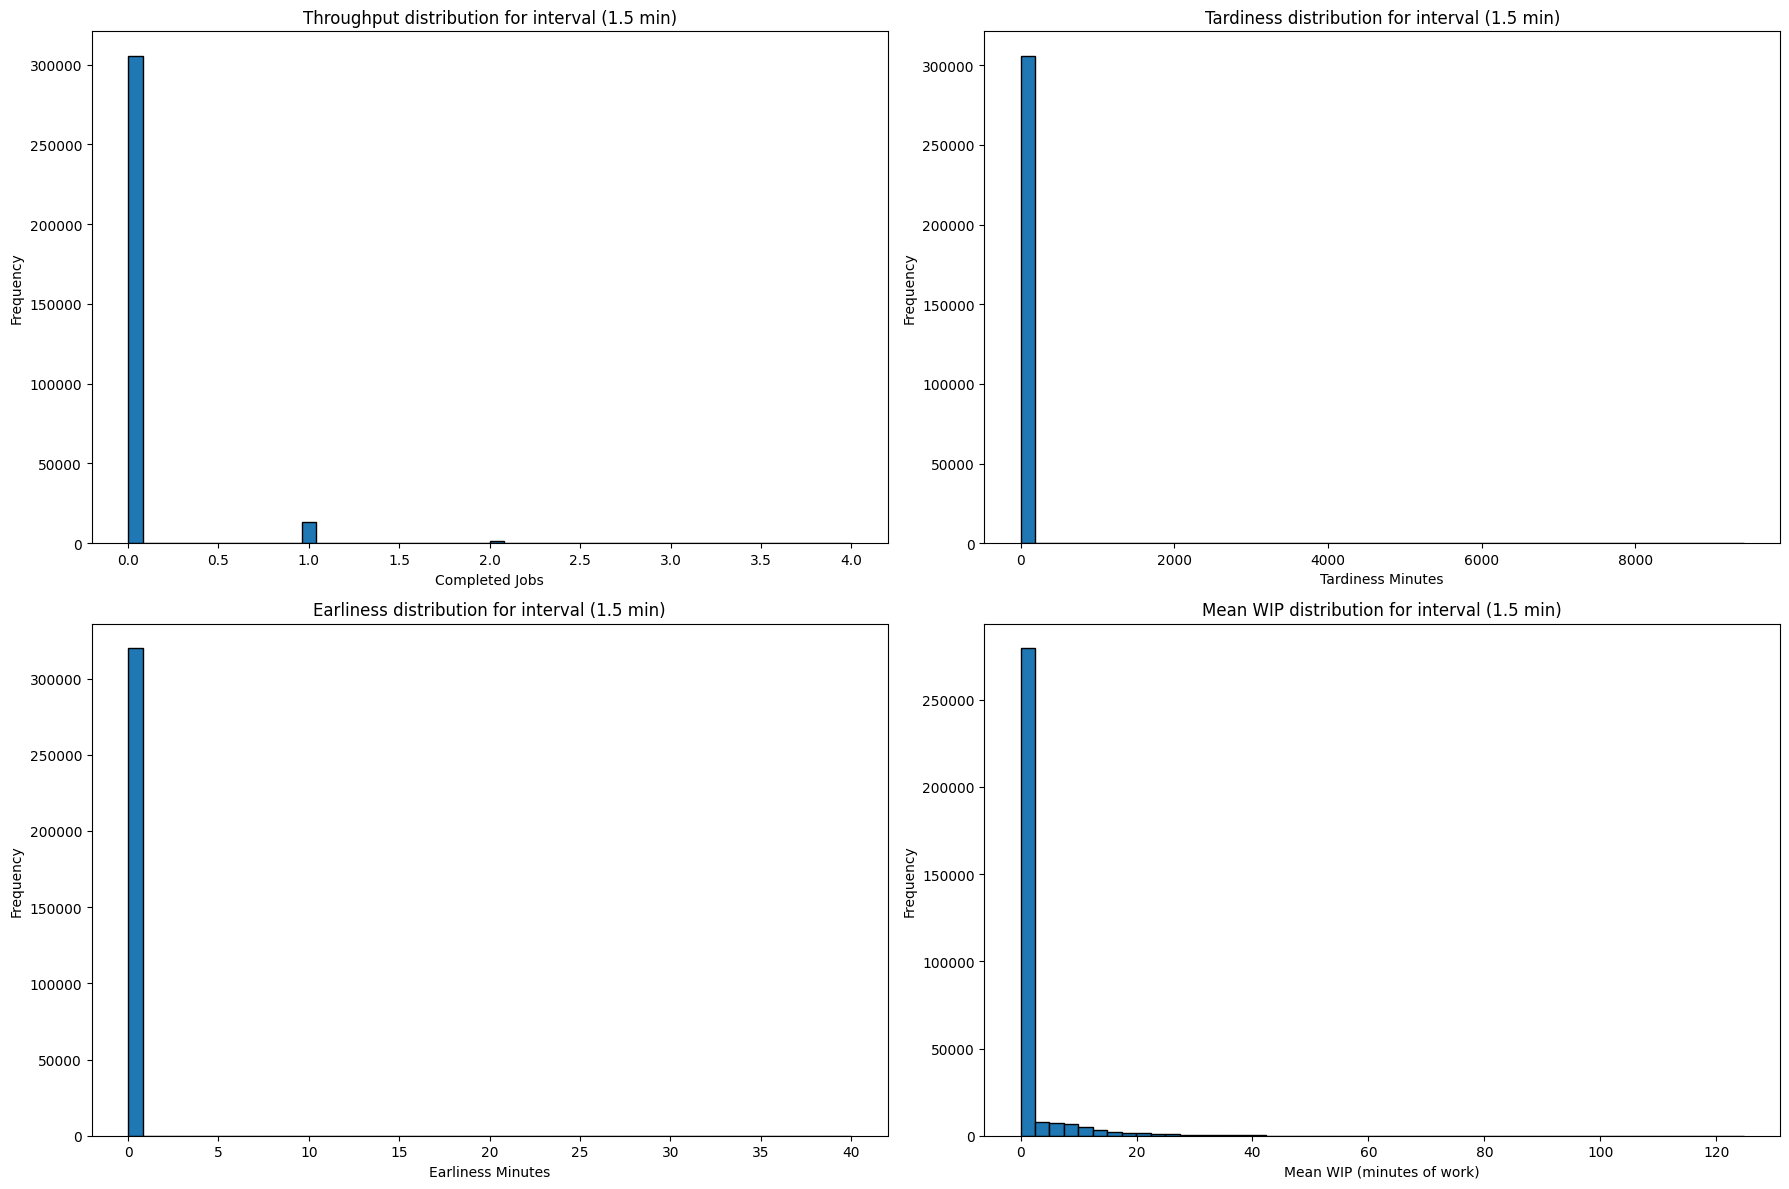

Obs - Job Top Proc Time: Min=0.53, Max=28.47
Obs - Job Top Urgency: Min=-9273.56, Max=-51.82


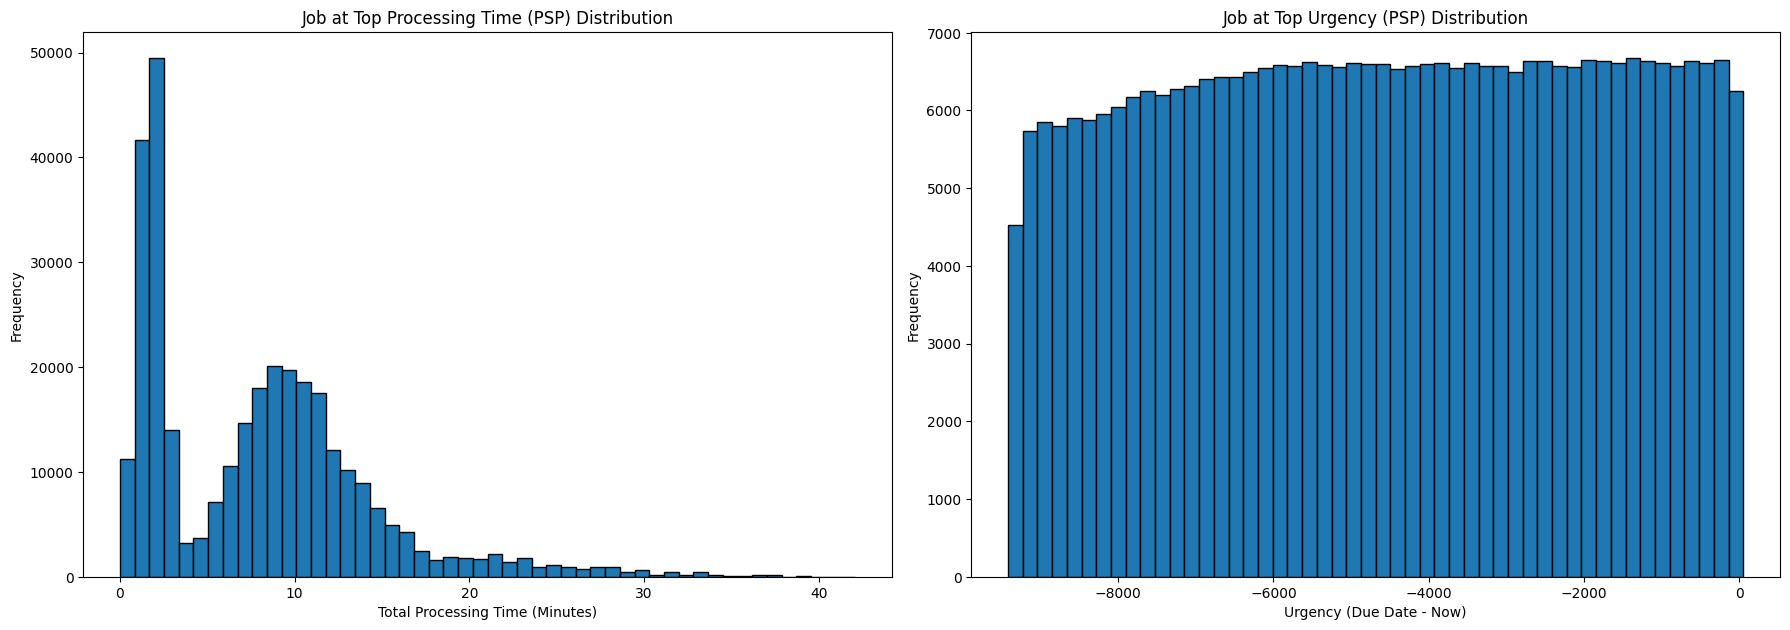

Obs - Machine Workloads (flattened): Min=0.00, Max=5.09


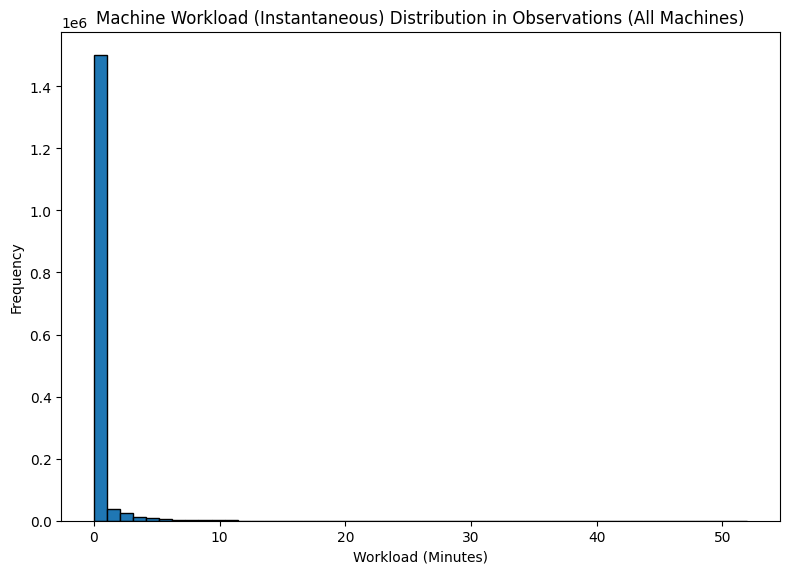


--- Summary of Calibrated Values to Insert into SystemEnv.py (for RL training) ---
# --- REWARD SCALING PARAMETERS ---
MIN_THROUGHPUT_INTERVAL = 0.00
MAX_THROUGHPUT_INTERVAL = 1.00
MIN_TARDINESS_INTERVAL = 0.00
MAX_TARDINESS_INTERVAL = 6271.90
MIN_EARLINESS_INTERVAL = 0.00
MAX_EARLINESS_INTERVAL = 0.00
MIN_WIP_WORK_CONTENT_INTERVAL = 0.00
MAX_WIP_WORK_CONTENT_INTERVAL = 24.62

# --- OBSERVATION SPACE BOUNDS ---
low_bounds = np.array([
    0.53, # job_top_proc_time
    -9273.56, # job_top_urgency
    0.00, # machine_workload WC1
    0.00, # machine_workload WC2
    0.00, # machine_workload WC3
    0.00, # machine_workload WC4
    0.00, # machine_workload WC5
    0.00, # machine_workload WC6
], dtype=np.float32)

high_bounds = np.array([
    28.47, # job_top_proc_time
    -51.82, # job_top_urgency
    5.09, # machine_workload WC1
    5.09, # machine_workload WC2
    5.09, # machine_workload WC3
    5.09, # machine_workload WC4
    5.09, # machine_workload WC5
    5.09, # machine_workloa

In [6]:
print(f"Starting calibration training for {N_THROW_AWAY_EPISODES} episodes.")
print(f"Total duration of an episode: {THROW_AWAY_EPISODE_DURATION/60:.0f} hours.")
print(f"Max decision interval of the agent (It will choose each time a job arrives): {THROW_AWAY_AGENT_DECISION_INTERVAL} minutes.")
print(f"Total Timesteps: {TOTAL_TIMESTEPS_FOR_THROWAWAY_TRAINING}.")

def make_env():
    return SystemEnv(
        inter_arrival_time_distribution=lambda: random.expovariate(lambd=0.65),
        processing_time_per_family_distribution=[
            lambda: random.gammavariate(2,2),
            lambda: random.gammavariate(4,0.5),
            lambda: random.gammavariate(6,1/6)
        ],
        families_distribution=lambda: random.random(),
        routing_distribution={
            1: [lambda: random.random(), lambda: random.random(), lambda: random.random(),lambda: random.random(),lambda: random.random(),lambda: random.random()],
            2: [lambda: random.random(), lambda: random.random(), lambda: random.random(),lambda: random.random(),lambda: random.random(),lambda: random.random()],
            3: [lambda: random.random(), lambda: random.random(), lambda: random.random(),lambda: random.random(),lambda: random.random(),lambda: random.random()]
        },
        routing_prob={
            1: [1,1,0,1,1,1],
            2: [0.8, 0.8, 1, 0.8, 0.8, 0.75],
            3: [0,0,1,0,0,0.75]
        },
        due_dates_distribution=lambda: random.uniform(30,50),
        reward_weights={
            'throughput': 1.0,
            'wip_penalty': -1,
            'earliness_penalty': -1,
            'tardiness_penalty': -1
        }
    )

seed = 42
vec_env = make_vec_env(make_env, n_envs=1, seed=42)
model = DQN(
    "MlpPolicy",
    vec_env,
    verbose=1,
    learning_rate=1e-4,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=32,
    tau=1.0,
    gamma=0.99,
    train_freq=(1, "step"),
    gradient_steps=1,
    exploration_fraction=0.1,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
    target_update_interval=1000,
    seed=seed
)
model.learn(total_timesteps=TOTAL_TIMESTEPS_FOR_THROWAWAY_TRAINING, log_interval=10)

print("\n--- Starting Calibration Analysis ---")

calib_env = vec_env.envs[0].env

def get_min_max_percentile(data: list[float], low_p: float=1, high_p: float=99, clip_min_to_zero: bool = True):
    if not data:
        print(f"Given list is empty.")
        return 0.0, 1.0

    data_np = np.array(data)
    data_np = data_np[np.isfinite(data_np)]
    if data_np.size == 0:
        print(f"Attention: no more values are left after filtering the infinite values")
        return 0.0, 1.0

    min_val = np.percentile(data_np, low_p)
    max_val = np.percentile(data_np, high_p)
    if clip_min_to_zero:
        return float(max(0.0, min_val)), float(max_val)
    return float(min_val), float(max_val)


plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
if calib_env.calibration_throughput_intervals:
    plt.hist(calib_env.calibration_throughput_intervals, bins=50, edgecolor='black')
    min_th, max_th = get_min_max_percentile(calib_env.calibration_throughput_intervals)
    plt.title(f'Throughput distribution for interval ({THROW_AWAY_AGENT_DECISION_INTERVAL} min)')
    plt.xlabel('Completed Jobs')
    plt.ylabel('Frequency')
    print(f"Reward - Throughput Interval: Min={min_th:.2f}, Max={max_th:.2f}")
else:
    print("No throughput data left")
    min_th, max_th = 0.0, 1.0

plt.subplot(2, 2, 2)
if calib_env.calibration_tardiness_intervals:
    plt.hist(calib_env.calibration_tardiness_intervals, bins=50, edgecolor='black')
    min_tardiness, max_tardiness = get_min_max_percentile(calib_env.calibration_tardiness_intervals)
    plt.title(f'Tardiness distribution for interval ({THROW_AWAY_AGENT_DECISION_INTERVAL} min)')
    plt.xlabel('Tardiness Minutes')
    plt.ylabel('Frequency')
    print(f"Reward - Tardiness Interval: Min={min_tardiness:.2f}, Max={max_tardiness:.2f}")
else:
    print("No tardiness data left")
    min_tardiness, max_tardiness = 0.0, 1.0

plt.subplot(2, 2, 3)
if calib_env.calibration_earliness_intervals:
    plt.hist(calib_env.calibration_earliness_intervals, bins=50, edgecolor='black')
    min_earliness, max_earliness = get_min_max_percentile(calib_env.calibration_earliness_intervals)
    plt.title(f'Earliness distribution for interval ({THROW_AWAY_AGENT_DECISION_INTERVAL} min)')
    plt.xlabel('Earliness Minutes')
    plt.ylabel('Frequency')
    print(f"Reward - Earliness Interval: Min={min_earliness:.2f}, Max={max_earliness:.2f}")
else:
    print("No earliness data left")
    min_earliness, max_earliness = 0.0, 1.0


plt.subplot(2, 2, 4)
if calib_env.calibration_avg_wip_intervals:
    plt.hist(calib_env.calibration_avg_wip_intervals, bins=50, edgecolor='black')
    min_wip_wc_reward, max_wip_wc_reward = get_min_max_percentile(calib_env.calibration_avg_wip_intervals)
    plt.title(f'Mean WIP distribution for interval ({THROW_AWAY_AGENT_DECISION_INTERVAL} min)')
    plt.xlabel('Mean WIP (minutes of work)')
    plt.ylabel('Frequency')
    print(f"Reward - WIP Interval: Min={min_wip_wc_reward:.2f}, Max={max_wip_wc_reward:.2f}")
else:
    print("No WIP data left")
    min_wip_wc_reward, max_wip_wc_reward = 0.0, 1.0 # Default se non ci sono dati

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
if calib_env.calibration_obs_job_top_proc_time:
    plt.hist(calib_env.calibration_obs_job_top_proc_time, bins=50, edgecolor='black')
    min_jtpt, max_jtpt = get_min_max_percentile(calib_env.calibration_obs_job_top_proc_time)
    plt.title('Job at Top Processing Time (PSP) Distribution')
    plt.xlabel('Total Processing Time (Minutes)')
    plt.ylabel('Frequency')
    print(f"Obs - Job Top Proc Time: Min={min_jtpt:.2f}, Max={max_jtpt:.2f}")
else:
    print("No job top processing time data collected for plotting.")
    min_jtpt, max_jtpt = 0.0, 1.0


plt.subplot(2, 2, 2)
if calib_env.calibration_obs_job_top_urgency:
    plt.hist(calib_env.calibration_obs_job_top_urgency, bins=50, edgecolor='black')
    min_jtu, max_jtu = get_min_max_percentile(calib_env.calibration_obs_job_top_urgency, clip_min_to_zero=False)
    plt.title('Job at Top Urgency (PSP) Distribution')
    plt.xlabel('Urgency (Due Date - Now)')
    plt.ylabel('Frequency')
    print(f"Obs - Job Top Urgency: Min={min_jtu:.2f}, Max={max_jtu:.2f}")
else:
    print("No job top urgency data collected for plotting.")
    min_jtu, max_jtu = -100.0, 100.0

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
if calib_env.calibration_obs_machine_workloads_flat:
    plt.hist(calib_env.calibration_obs_machine_workloads_flat, bins=50, edgecolor='black')
    min_mw, max_mw = get_min_max_percentile(calib_env.calibration_obs_machine_workloads_flat)
    plt.title('Machine Workload (Instantaneous) Distribution in Observations (All Machines)')
    plt.xlabel('Workload (Minutes)')
    plt.ylabel('Frequency')
    print(f"Obs - Machine Workloads (flattened): Min={min_mw:.2f}, Max={max_mw:.2f}")
else:
    print("No machine workload data collected for plotting.")
    min_mw, max_mw = 0.0, 1.0

plt.tight_layout()
plt.show()


print("\n--- Summary of Calibrated Values to Insert into SystemEnv.py (for RL training) ---")
print("# --- REWARD SCALING PARAMETERS ---")
print(f"MIN_THROUGHPUT_INTERVAL = {min_th:.2f}")
print(f"MAX_THROUGHPUT_INTERVAL = {max_th:.2f}")
print(f"MIN_TARDINESS_INTERVAL = {min_tardiness:.2f}")
print(f"MAX_TARDINESS_INTERVAL = {max_tardiness:.2f}")
print(f"MIN_EARLINESS_INTERVAL = {min_earliness:.2f}")
print(f"MAX_EARLINESS_INTERVAL = {max_earliness:.2f}")
print(f"MIN_WIP_WORK_CONTENT_INTERVAL = {min_wip_wc_reward:.2f}")
print(f"MAX_WIP_WORK_CONTENT_INTERVAL = {max_wip_wc_reward:.2f}")

print("\n# --- OBSERVATION SPACE BOUNDS ---")
print("low_bounds = np.array([")
print(f"    {min_jtpt:.2f}, # job_top_proc_time")
print(f"    {min_jtu:.2f}, # job_top_urgency")
for i in range(6):
    print(f"    {min_mw:.2f}, # machine_workload WC{i+1}")
print("], dtype=np.float32)")

print("\nhigh_bounds = np.array([")
print(f"    {max_jtpt:.2f}, # job_top_proc_time")
print(f"    {max_jtu:.2f}, # job_top_urgency")
for i in range(6):
    print(f"    {max_mw:.2f}, # machine_workload WC{i+1}")
print("], dtype=np.float32)")

vec_env.close()


## WELCH

In [4]:
class Welch:
    def __init__(self, process: np.ndarray, window_size: int, tol: float) -> None:
        self.process = process
        self.window_size = window_size
        self.tol = tol
        self.replications_mean = np.mean(process, axis=0)
        self.averaged_process = self._welch()
        self.diff, self.warmup_period = self._find_steady_state()

    @staticmethod
    def moving_average(arr: np.ndarray, window_size: int) -> np.ndarray:
        weights = np.ones(window_size) / window_size
        return np.convolve(arr, weights, mode="valid")

    def _welch(self) -> np.ndarray:
        averaged_process = []
        for i in range(1, self.replications_mean.shape[0] - self.window_size): # +1):
            if i <= self.window_size:
                averaged_process.append(self.replications_mean[: 2 * i - 1].mean())
            else:
                averaged_process.append(
                    self.replications_mean[
                        (i - 1 - self.window_size) : (i + self.window_size)
                    ].mean()
                )
        return np.array(averaged_process)

    def _find_steady_state(self) -> tuple[np.ndarray, int]:
        arr = self.averaged_process
        diff = np.diff(arr.flatten())
        for i, d in enumerate(diff):
            if d < self.tol:
                return diff, i + self.window_size
        return diff, -1

    def plot(self):
        plt.plot(self.averaged_process, label="Averaged Process")
        plt.axvline(
            self.warmup_period,
            color="r",
            linestyle="--",
            label=f"Warmup period: {self.warmup_period}",
        )
        plt.legend(loc="best")
        plt.show()


In [5]:
def t_student_critical_value(alpha: float, n: int):
    return stats.t.ppf(1 - alpha, n - 1)

## Actual RL Agent Training

In [73]:
MIN_THROUGHPUT_INTERVAL = 0.0
MAX_THROUGHPUT_INTERVAL = 1.0
MIN_TARDINESS_INTERVAL = 0.0
MAX_TARDINESS_INTERVAL = 6500.0
MIN_EARLINESS_INTERVAL = 0.0
MAX_EARLINESS_INTERVAL = 1.0
MIN_WIP_WORK_CONTENT_INTERVAL = 0.0
MAX_WIP_WORK_CONTENT_INTERVAL = 25.0

In [80]:
class SystemEnv(gym.Env):
    def __init__(
        self,
        inter_arrival_time_distribution: Callable[[], float],
        processing_time_per_family_distribution: list[Callable[[], float]],
        families_distribution: Callable[[], float],
        due_dates_distribution: Callable[[], float],
        routing_distribution: dict[int, list[Callable[[], float]]],
        routing_prob: dict[int, list[float]],
        agent_decision_interval: float = 3.0,
        episode_duration: float = 60 * 160,
        reward_weights: dict[str, float] = None,
        wip_warmup: int | None = None
    ) -> None:
        super().__init__()
        self.env: simpy.Environment | None = None
        self.inter_arrival_time_distribution = inter_arrival_time_distribution
        self.processing_time_per_family_distribution = processing_time_per_family_distribution
        self.families_distribution = families_distribution
        self.due_dates_distribution = due_dates_distribution
        self.routing_distribution = routing_distribution
        self.routing_prob = routing_prob
        self.agent_decision_interval = agent_decision_interval
        self.episode_duration = episode_duration
        self.wip_warmup = wip_warmup

        self.e  = 0
        self.reward_weights = reward_weights if reward_weights is not None else {
            'throughput': 1.0,
            'wip_penalty': -1.0,
            'tardiness_penalty': -1.0,
            'earliness_penalty': -1.0
        }

        low_bounds = np.array([
            0.0,
            0.0,
            -10000.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0
        ], dtype=np.float32)

        high_bounds = np.array([
            1.0,
            35.0,
            50.0,
            100.0,
            100.0,
            100.0,
            100.0,
            100.0,
            100.0
        ], dtype=np.float32)

        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

        # action space: 0 = Don't Release, 1 = Release
        self.action_space = spaces.Discrete(2)

        self.machines: list[Server] = []
        self.jobs: list[Job] = []
        self.pre_shop_pool: list[Job] = []
        self.idx_counter = 0

        self.jobs_completed_in_current_interval: list[Job] = []
        self.jobs_completed_in_current_episode: list[Job] = []

        self.th_stats: list[int] = []
        self.last_total_th = 0

        self.tis_stats: list[float] = []

        self.tardiness_stats: list[float] = []
        self.earliness_stats: list[float] = []
        self.WIP_stats: list[float] = []

        self.last_wip_value: float = 0.0
        self.last_wip_time: float = 0.0
        self.cumulative_wip_area: float = 0.0
        self.cumulative_wip_area_after_warmup: float = 0.0
        self.current_interval_wip_area: float = 0.0

        self.next_scheduled_arrival_time = float('inf')

    def compute_wip_for_servers(self) -> list[float]:
        servers_wip = [0.0] * 6
        for idx, server in enumerate(self.machines):
            server_wip = 0
            for job in [job for job in self.jobs if not job.done and job.in_system]:
                try:
                    if server in job.routing:
                        server_idx_for_current_job = job.routing.index(server)
                        if server_idx_for_current_job >= job.current_step_index:
                            server_wip += job.process_times[server_idx_for_current_job]

                            if job.current_step_index == server_idx_for_current_job and \
                                    job.current_process_start_time is not None and \
                                    server.job_on_machine == job:
                                time_spent_in_current_op = self.env.now - job.current_process_start_time
                                server_wip -= min(time_spent_in_current_op, job.process_times[server_idx_for_current_job])
                                server_wip = max(0.0, server_wip)

                except ValueError:
                    pass
            servers_wip[idx] = server_wip
        return servers_wip

    def _hourly_stats_sampler(self):
        while True:
            yield self.env.timeout(60.0)

            delta = len(self.jobs_completed_in_current_episode) - self.last_total_th
            self.th_stats.append(delta)
            self.last_total_th = len(self.jobs_completed_in_current_episode)

            if self.jobs_completed_in_current_episode:
                mean_tis = statistics.mean([j.time_in_system for j in self.jobs_completed_in_current_episode])
                mean_tardiness = statistics.mean([j.tardiness for j in self.jobs_completed_in_current_episode])
                mean_earliness = statistics.mean([j.earliness for j in self.jobs_completed_in_current_episode])
            else:
                mean_tis = 0.0
                mean_tardiness = 0.0
                mean_earliness = 0.0


            self.tis_stats.append(mean_tis)
            self.tardiness_stats.append(mean_tardiness)
            self.earliness_stats.append(mean_earliness)

            self.WIP_stats.append(self.cumulative_wip_area / self.env.now)

    def _update_wip_area(self):
        now = self.env.now
        duration = now - self.last_wip_time
        if duration > 0:
            self.cumulative_wip_area += self.last_wip_value * duration
            self.current_interval_wip_area += self.last_wip_value * duration
            if self.wip_warmup is not None and (self.env.now / 60) > self.wip_warmup:
                self.cumulative_wip_area_after_warmup += self.last_wip_value * duration
        self.last_wip_time = now
        self.last_wip_value = sum(self.compute_wip_for_servers())

    def _set_seed(self, seed: int | None = None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

    def reset(self, seed: int | None = None, options: dict | None = None) -> tuple[np.ndarray, dict]:
        super().reset(seed=seed)
        self._set_seed(seed)
        print("Env Reset: Initializing system...")

        self.env = simpy.Environment()
        self.machines = [Server(self.env, 1, f"WC{i+1}") for i in range(6)]
        self.pre_shop_pool = []
        self.jobs = []

        self.idx_counter = 0

        self.jobs_completed_in_current_interval = []
        self.jobs_completed_in_current_episode = []

        self.th_stats = []
        self.last_total_th = 0

        self.tis_stats = []

        self.tardiness_stats = []
        self.earliness_stats = []
        self.WIP_stats = []

        self.last_wip_value = 0
        self.last_wip_time = self.env.now
        self.cumulative_wip_area = 0.0
        self.cumulative_wip_area_after_warmup = 0.0
        self.current_interval_wip_area = 0.0

        self.next_scheduled_arrival_time = float('inf')

        self.env.process(self._run_job_arrivals())
        self.env.process(self._hourly_stats_sampler())

        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    def step(self, action: int) -> tuple[np.ndarray, float, bool, bool, dict]:
        self.jobs_completed_in_current_interval = []

        self.current_interval_wip_area = 0.0
        self._update_wip_area()

        if action == 1:
            self._release_job_from_psp()
            self._update_wip_area()

        # print(f"  SystemEnv Step: Action received: {action}")
        time_to_advance = self.agent_decision_interval
        if self.next_scheduled_arrival_time < self.env.now + self.agent_decision_interval:
            time_to_advance = self.next_scheduled_arrival_time - self.env.now

        time_to_advance = max(1e-9, time_to_advance) # to make sure that the simulation will proceed, even if for a very short time
        self.env.run(until=self.env.now + time_to_advance)

        jobs_completed_in_interval = len(self.jobs_completed_in_current_interval)
        if jobs_completed_in_interval > 0:
            avg_tardiness_in_interval = sum(j.tardiness for j in self.jobs_completed_in_current_interval) / jobs_completed_in_interval
            avg_earliness_in_interval = sum(j.earliness for j in self.jobs_completed_in_current_interval) / jobs_completed_in_interval
        else:
            avg_tardiness_in_interval = 0.0
            avg_earliness_in_interval = 0.0

        self._update_wip_area()

        if self.env.now >= self.next_scheduled_arrival_time - 1e-9:
            self.next_scheduled_arrival_time = float('inf')

        avg_wip_for_reward_interval = self.current_interval_wip_area / time_to_advance if time_to_advance > 0 else 0.0


        reward = self._calculate_reward(
            jobs_completed_in_interval,
            avg_tardiness_in_interval,
            avg_earliness_in_interval,
            avg_wip_for_reward_interval
        )

        terminated = self.env.now >= self.episode_duration
        if terminated:
            print(f"Episode {self.e} terminated")
            self.e += 1
        truncated = False

        observation = self._get_obs()

        info = self._get_info()

        if terminated:
            self._update_wip_area()
            average_wip_for_episode = self.cumulative_wip_area / self.episode_duration if self.episode_duration > 0 else 0
            info["average_wip_for_episode"] = average_wip_for_episode
            info["total_simulation_time_minutes"] = self.env.now

            info["hourly_throughput_stats"] = self.th_stats
            info["tis_stats"] = self.tis_stats
            info["tardiness_stats"] = self.tardiness_stats
            info["earliness_stats"] = self.earliness_stats
            info["wip_stats"] = self.WIP_stats

            if self.cumulative_wip_area_after_warmup != 0:
                info["wip_after_warmup"] = self.cumulative_wip_area_after_warmup / (self.env.now - self.wip_warmup * 60)

        return observation, reward, terminated, truncated, info

    def _get_obs(self) -> np.ndarray:
        presence_job_top = 1.0 if self.pre_shop_pool else 0.0

        job_top_proc_time = 0.0
        job_top_urgency = 0.0
        if presence_job_top == 1.0:
            job_top = self.pre_shop_pool[0]
            job_top_proc_time = job_top.total_processing_time
            job_top_urgency = job_top.due_date - self.env.now


        machine_workloads = self.compute_wip_for_servers()

        return np.array([
            presence_job_top,
            job_top_proc_time,
            job_top_urgency,
            *machine_workloads
        ], dtype=np.float32)

    def _run_job_arrivals(self) -> ProcessGenerator:
        while True:
            timeout_inter_arrival = self.inter_arrival_time_distribution()
            self.next_scheduled_arrival_time = self.env.now + timeout_inter_arrival
            yield self.env.timeout(timeout_inter_arrival)

            weight = self.families_distribution()
            if weight <= 0.1:
                family = 1
            elif weight <= 0.62:
                family = 2
            else:
                family = 3

            due_date_offset = self.due_dates_distribution()

            family_routing_distr = self.routing_distribution[family]
            family_routing_prob = self.routing_prob[family]

            job_routing = []
            processing_times = []
            for i in range(6):
                if family_routing_distr[i]() <= family_routing_prob[i]:
                    job_routing.append(self.machines[i])
                    processing_times.append(self.processing_time_per_family_distribution[family-1]())

            job = Job(
                env=self.env,
                routing=job_routing,
                arrival_time=self.env.now,
                process_times=processing_times,
                due_date=(self.env.now + due_date_offset),
                idx=self.idx_counter,
                family="F{}".format(family),
                completion_callback=self._job_completed_callback
            )

            self.idx_counter += 1
            self.jobs.append(job)
            self.pre_shop_pool.append(job)

    def _release_job_from_psp(self):
        if self.pre_shop_pool:
            job_to_release = self.pre_shop_pool.pop(0)

            job_to_release.in_system = True
            self.env.process(job_to_release.main())


    def _job_completed_callback(self, job: Job):
        job.in_system = False
        self.jobs_completed_in_current_interval.append(job)
        self.jobs_completed_in_current_episode.append(job)


    def _calculate_reward(self, jobs_completed_in_interval: int, tardiness_in_interval: float, earliness_in_interval: float, avg_wip_for_reward_interval: int) -> float:

        scaled_throughput = (jobs_completed_in_interval - MIN_THROUGHPUT_INTERVAL) / \
                            (MAX_THROUGHPUT_INTERVAL - MIN_THROUGHPUT_INTERVAL + 1e-8)
        scaled_tardiness = (tardiness_in_interval - MIN_TARDINESS_INTERVAL) / \
                           (MAX_TARDINESS_INTERVAL - MIN_TARDINESS_INTERVAL + 1e-8)
        scaled_earliness = (earliness_in_interval - MIN_EARLINESS_INTERVAL) / \
                           (MAX_EARLINESS_INTERVAL - MIN_EARLINESS_INTERVAL + 1e-8)
        scaled_wip = (avg_wip_for_reward_interval - MIN_WIP_WORK_CONTENT_INTERVAL) / \
                     (MAX_WIP_WORK_CONTENT_INTERVAL - MIN_WIP_WORK_CONTENT_INTERVAL + 1e-8)

        reward = (self.reward_weights['throughput'] * scaled_throughput) + \
                 (self.reward_weights['tardiness_penalty'] * scaled_tardiness) + \
                 (self.reward_weights['earliness_penalty'] * scaled_earliness) + \
                 (self.reward_weights['wip_penalty'] * scaled_wip)
        return reward

    def _get_info(self) -> dict:
        info = {
            "current_time": self.env.now,
            "jobs_in_psp": len(self.pre_shop_pool),
            "mean_wip": self.cumulative_wip_area / self.env.now if self.env.now != 0.0 else 0.0
        }
        return info


In [9]:
def make_env(wip_warmup: int | None = None):
    return SystemEnv(
        inter_arrival_time_distribution=lambda: random.expovariate(lambd=0.65),
        processing_time_per_family_distribution=[
            lambda: random.gammavariate(2,2),
            lambda: random.gammavariate(4,0.5),
            lambda: random.gammavariate(6,1/6)
        ],
        families_distribution=lambda: random.random(),
        routing_distribution={
            1: [lambda: random.random(), lambda: random.random(), lambda: random.random(),lambda: random.random(),lambda: random.random(),lambda: random.random()],
            2: [lambda: random.random(), lambda: random.random(), lambda: random.random(),lambda: random.random(),lambda: random.random(),lambda: random.random()],
            3: [lambda: random.random(), lambda: random.random(), lambda: random.random(),lambda: random.random(),lambda: random.random(),lambda: random.random()]
        },
        routing_prob={
            1: [1,1,0,1,1,1],
            2: [0.8, 0.8, 1, 0.8, 0.8, 0.75],
            3: [0,0,1,0,0,0.75]
        },
        due_dates_distribution=lambda: random.uniform(30,50),
        reward_weights={
            'throughput': 5.0,
            'wip_penalty': -0.1,
            'earliness_penalty': -0.1,
            'tardiness_penalty': -0.3
        },
        wip_warmup=wip_warmup
    )

num_envs = 4
seed = 42

vec_env = make_vec_env(make_env, n_envs=num_envs, seed=seed)
vec_env = VecNormalize(
    vec_env,
    norm_obs=True,
    norm_reward=True,
    clip_obs=10,
    clip_reward=10,
    gamma=0.99
)

model = DQN(
    "MlpPolicy",
    vec_env,
    verbose=1,
    learning_rate=1e-4,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=32,
    tau=1.0,
    gamma=0.99,
    train_freq=(1, "step"),
    gradient_steps=1,
    exploration_fraction=0.1,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
    target_update_interval=1000,
    seed=seed
)

print("Starting DQN training...")
total_timesteps = 1000000
model.learn(total_timesteps=total_timesteps, log_interval=10)
print("DQN training finished")

model.save("production_system_agent_dqn_final")
vec_env.save("vec_normalize_stats_dqn_final.pkl")

Using cpu device
Starting DQN training...
Env Reset: Initializing system...
Env Reset: Initializing system...
Env Reset: Initializing system...
Env Reset: Initializing system...
Episode 0 terminated
Env Reset: Initializing system...
Episode 0 terminated
Env Reset: Initializing system...
Episode 0 terminated
Env Reset: Initializing system...
Episode 0 terminated
Env Reset: Initializing system...
Episode 1 terminated
Env Reset: Initializing system...
Episode 1 terminated
Env Reset: Initializing system...
Episode 1 terminated
Env Reset: Initializing system...
Episode 1 terminated
Env Reset: Initializing system...
Episode 2 terminated
Env Reset: Initializing system...
Episode 2 terminated
Env Reset: Initializing system...
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.57e+03 |
|    ep_rew_mean      | 1.21e+04 |
|    exploration_rate | 0.479    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 141

## Evaluation

In [35]:
hourly_throughput_stats = []
tis_stats = []
tardiness_stats = []
earliness_stats = []
wip_stats = []
completed_jobs_for_episode = {}

In [38]:
print("\nStarting evaluation phase...")

num_eval_episodes = 10
episode_rewards = []

metrics_of_interest = ["hourly_throughput_stats", "tis_stats", "tardiness_stats", "earliness_stats", "wip_stats"]

eval_env = make_vec_env(make_env, n_envs=1, seed=SEEDS[0])
eval_env = VecNormalize.load("vec_normalize_stats_dqn_final.pkl", eval_env)
eval_env.training = False
eval_env.norm_reward = False
model = DQN.load("production_system_agent_dqn_final", eval_env)

for idx_m, metric in enumerate(metrics_of_interest):
    print(f"\n--- Evaluating for metric: {metric.upper()} ---")
    for episode in range(num_eval_episodes):
        current_episode_seed = SEEDS[idx_m * num_eval_episodes + episode]

        eval_env.seed(seed=current_episode_seed)
        obs = eval_env.reset()
        print(f"Type of reset_result: {type(obs)}")
        print(f"Value of reset_result: {obs}")

        done = False
        total_reward = 0
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done_status_array, info = eval_env.step(action)
            total_reward += reward[0]

            if done_status_array[0]:
                print("done_status_array is true")
                episode_rewards.append(total_reward)

                if metric == "hourly_throughput_stats":
                    hourly_throughput_stats.append(info[0]["hourly_throughput_stats"])
                    completed_jobs_for_episode["hourly_throughput"].append(info[0]["jobs_completed_in_episode"])
                elif metric == "tis_stats" :
                    tis_stats.append(info[0]["tis_stats"])
                    completed_jobs_for_episode["tis"].append(info[0]["jobs_completed_in_episode"])
                elif metric == "tardiness_stats":
                    tardiness_stats.append(info[0]["tardiness_stats"])
                    completed_jobs_for_episode["tardiness"].append(info[0]["jobs_completed_in_episode"])
                elif metric == "earliness_stats":
                    earliness_stats.append(info[0]["earliness_stats"])
                    completed_jobs_for_episode["earliness"].append(info[0]["jobs_completed_in_episode"])
                elif metric == "wip_stats":
                    wip_stats.append(info[0]["wip_stats"])
                    completed_jobs_for_episode["wip"].append(info[0]["jobs_completed_in_episode"])

                done = True

if eval_env is not None:
    eval_env.close()
    print("Final environment closed.")

print(f"\nEvaluation on {num_eval_episodes} episodes:")
print(f"Average Reward per episode: {np.mean(episode_rewards):.2f}")

eval_env.close()



Starting evaluation phase...

--- Evaluating for metric: HOURLY_THROUGHPUT_STATS ---
Env Reset: Initializing system...
Type of reset_result: <class 'numpy.ndarray'>
Value of reset_result: [[-10.          -1.2140912    1.6450498   -0.43725333  -0.70039696
   -0.99644405  -1.0707635   -1.2050494   -1.3730892 ]]
Episode 0 terminated
Env Reset: Initializing system...
done_status_array is true
Env Reset: Initializing system...
Type of reset_result: <class 'numpy.ndarray'>
Value of reset_result: [[-10.          -1.2140912    1.6450498   -0.43725333  -0.70039696
   -0.99644405  -1.0707635   -1.2050494   -1.3730892 ]]
Episode 1 terminated
Env Reset: Initializing system...
done_status_array is true
Env Reset: Initializing system...
Type of reset_result: <class 'numpy.ndarray'>
Value of reset_result: [[-10.          -1.2140912    1.6450498   -0.43725333  -0.70039696
   -0.99644405  -1.0707635   -1.2050494   -1.3730892 ]]
Episode 2 terminated
Env Reset: Initializing system...
done_status_array i

## Hourly Throughput Warmup Evaluation

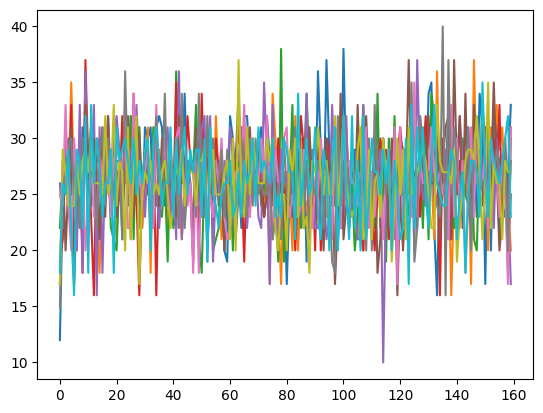

In [40]:
system_arr = np.array(hourly_throughput_stats)
plt.plot(system_arr.T)
plt.show()

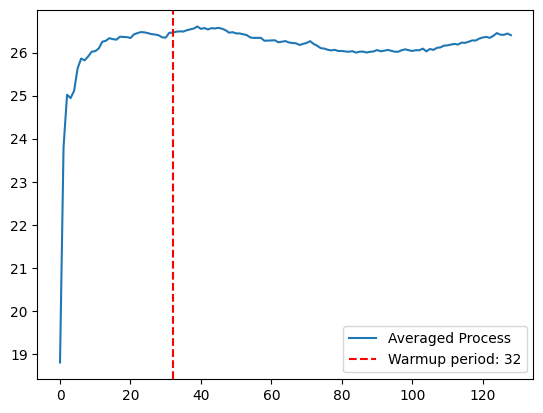

In [41]:
welch = Welch(system_arr, window_size=30, tol=0.1)
welch.plot()

In [42]:
hourly_throughput_warmup_period = welch.warmup_period

## TIS Warmup Evaluation

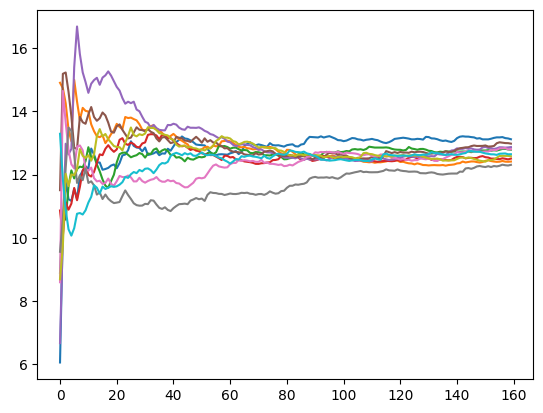

In [43]:
system_arr = np.array(tis_stats)
plt.plot(system_arr.T)
plt.show()

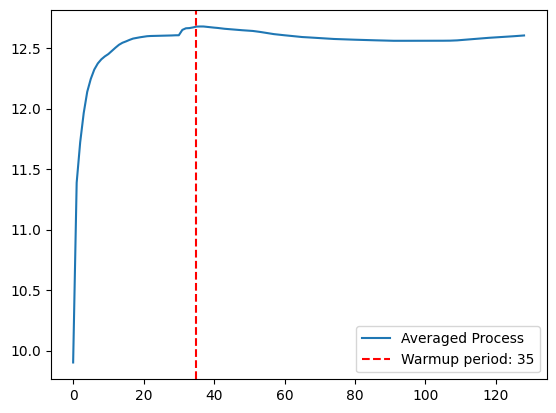

In [44]:
welch = Welch(system_arr, window_size=30, tol=0.1)
welch.plot()

In [45]:
tis_warmup_period = welch.warmup_period

## Tardiness Warmup Evaluation

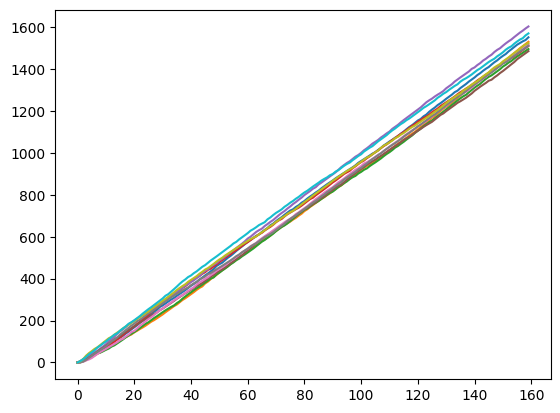

In [46]:
system_arr = np.array(tardiness_stats)
plt.plot(system_arr.T)
plt.show()

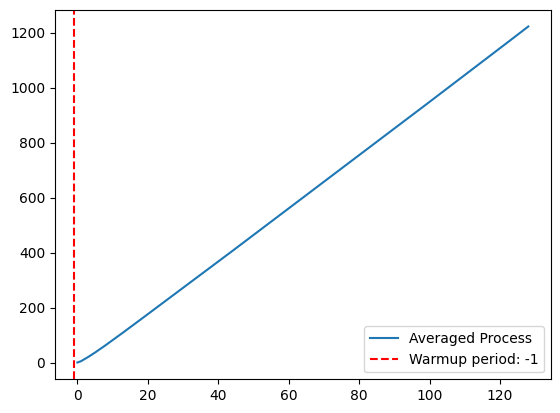

In [47]:
welch = Welch(system_arr, window_size=30, tol=0.1)
welch.plot()

In [48]:
tardiness_warmup_period = welch.warmup_period

## Earliness Warmup Evaluation

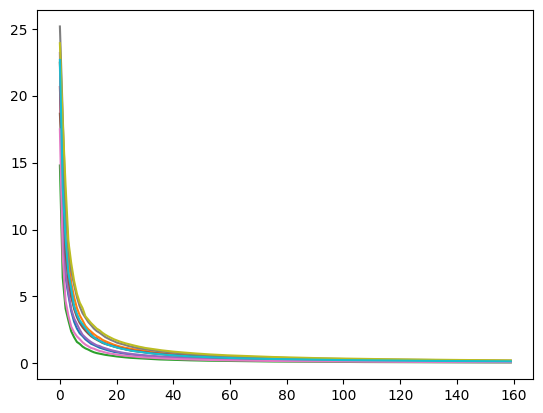

In [49]:
system_arr = np.array(earliness_stats)
plt.plot(system_arr.T)
plt.show()

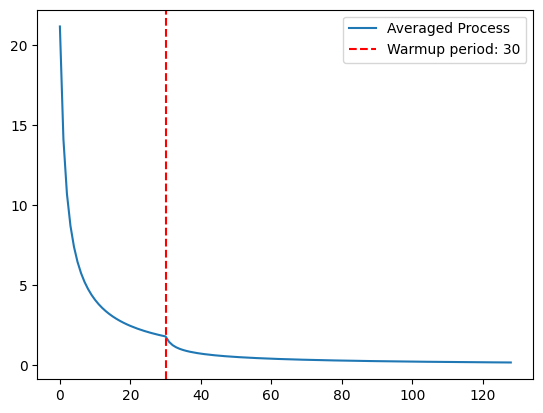

In [50]:
welch = Welch(system_arr, window_size=30, tol=0.1)
welch.plot()

In [51]:
earliness_warmup_period = welch.warmup_period

## WIP Warmup Evaluation

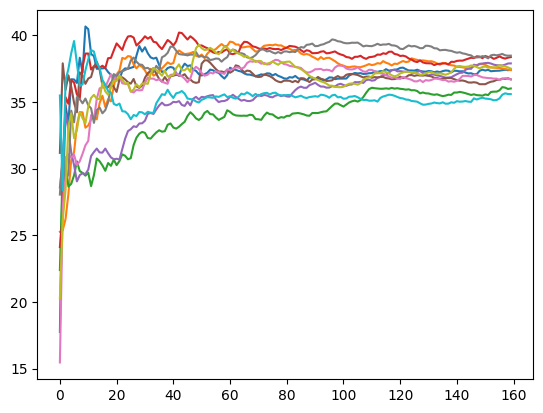

In [52]:
system_arr = np.array(wip_stats)
plt.plot(system_arr.T)
plt.show()

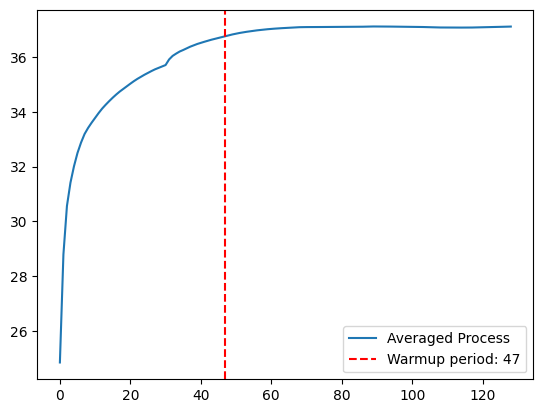

In [53]:
welch = Welch(system_arr, window_size=30, tol=0.1)
welch.plot()

In [54]:
wip_warmup_period = welch.warmup_period

In [ ]:
def analyze_hourly_throughput(
    runs: list[list[int]], warmup_period: int, alpha: float = 0.05
) -> tuple[float, float, float]:
    n = len(runs)
    sample = [statistics.mean(run.th_stats[warmup_period:]) for run in runs]
    throughput_sample_mean = statistics.mean(sample)
    throughput_sample_variance = statistics.variance(
        sample, xbar=throughput_sample_mean
    )
    t = t_student_critical_value(alpha=alpha, n=n)
    half_interval = t * np.sqrt(throughput_sample_variance / n)
    return throughput_sample_mean, throughput_sample_variance, half_interval

## Stats Evaluation

In [101]:
base_seed_idx = 51

In [102]:
hourly_throughput_stats = []
tis_stats = []
tardiness_stats = []
earliness_stats = []
wip_stats = []
completed_jobs_for_episode = {
    "tis": [],
    "tardiness": [],
    "earliness": []
}

In [103]:
print("\nStarting evaluation phase...")

num_eval_episodes = 10
episode_rewards = []

metrics_of_interest = ["hourly_throughput_stats", "tis_stats", "tardiness_stats", "earliness_stats", "wip_stats"]

eval_env = make_vec_env(lambda: make_env(wip_warmup=wip_warmup_period), n_envs=1, seed=SEEDS[base_seed_idx])
eval_env = VecNormalize.load("vec_normalize_stats_dqn_final.pkl", eval_env)
eval_env.training = False
eval_env.norm_reward = False
model = DQN.load("production_system_agent_dqn_final", eval_env)

for idx_m, metric in enumerate(metrics_of_interest):
    print(f"\n--- Evaluating for metric: {metric.upper()} ---")
    for episode in range(num_eval_episodes):
        current_episode_seed = SEEDS[base_seed_idx + idx_m * num_eval_episodes + episode]

        eval_env.seed(seed=current_episode_seed)
        obs = eval_env.reset()
        print(f"Type of reset_result: {type(obs)}")
        print(f"Value of reset_result: {obs}")

        done = False
        total_reward = 0
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done_status_array, info = eval_env.step(action)
            total_reward += reward[0]

            if done_status_array[0]:
                print("done_status_array is true")
                episode_rewards.append(total_reward)

                if metric == "hourly_throughput_stats":
                    hourly_throughput_stats.append(info[0]["hourly_throughput_stats"])
                elif metric == "tis_stats" :
                    tis_stats.append(info[0]["tis_stats"])
                    completed_jobs_for_episode["tis"].append(copy.deepcopy(eval_env.get_attr("jobs_completed_in_current_episode")[0]))
                elif metric == "tardiness_stats":
                    tardiness_stats.append(info[0]["tardiness_stats"])
                    completed_jobs_for_episode["tardiness"].append(copy.deepcopy(eval_env.get_attr("jobs_completed_in_current_episode")[0]))
                elif metric == "earliness_stats":
                    earliness_stats.append(info[0]["earliness_stats"])
                    completed_jobs_for_episode["earliness"].append(copy.deepcopy(eval_env.get_attr("jobs_completed_in_current_episode")[0]))
                elif metric == "wip_stats":
                    wip_stats.append(info[0]["wip_after_warmup"])

                done = True

if eval_env is not None:
    eval_env.close()
    print("Final environment closed.")

print(f"\nEvaluation on {num_eval_episodes} episodes:")
print(f"Average Reward per episode: {np.mean(episode_rewards):.2f}")

eval_env.close()



Starting evaluation phase...

--- Evaluating for metric: HOURLY_THROUGHPUT_STATS ---
Env Reset: Initializing system...
Type of reset_result: <class 'numpy.ndarray'>
Value of reset_result: [[-10.          -1.2140912    1.6450498   -0.43725333  -0.70039696
   -0.99644405  -1.0707635   -1.2050494   -1.3730892 ]]
Episode 0 terminated
Env Reset: Initializing system...
done_status_array is true
Env Reset: Initializing system...
Type of reset_result: <class 'numpy.ndarray'>
Value of reset_result: [[-10.          -1.2140912    1.6450498   -0.43725333  -0.70039696
   -0.99644405  -1.0707635   -1.2050494   -1.3730892 ]]
Episode 1 terminated
Env Reset: Initializing system...
done_status_array is true
Env Reset: Initializing system...
Type of reset_result: <class 'numpy.ndarray'>
Value of reset_result: [[-10.          -1.2140912    1.6450498   -0.43725333  -0.70039696
   -0.99644405  -1.0707635   -1.2050494   -1.3730892 ]]
Episode 2 terminated
Env Reset: Initializing system...
done_status_array i

## Hourly Throughput Stats Evaluation

In [105]:
def analyze_hourly_throughput(
    runs: list[list[int]], warmup_period: int, alpha: float = 0.05
) -> tuple[float, float, float]:
    n = len(runs)
    sample = [statistics.mean(run[warmup_period:]) for run in runs]
    throughput_sample_mean = statistics.mean(sample)
    throughput_sample_variance = statistics.variance(
        sample, xbar=throughput_sample_mean
    )
    t = t_student_critical_value(alpha=alpha, n=n)
    half_interval = t * np.sqrt(throughput_sample_variance / n)
    return throughput_sample_mean, throughput_sample_variance, half_interval

In [106]:
alpha = 0.05
throughput_sample_mean, throughput_sample_variance, half_interval = (
    analyze_hourly_throughput(
        hourly_throughput_stats, warmup_period=hourly_throughput_warmup_period, alpha=alpha
    )
)
print(f"Throughput Sample Mean: {throughput_sample_mean:.2f}")
print(f"Throughput Sample Variance: {throughput_sample_variance:.2f}")
print(f"Half Interval: {half_interval:.2f}")
print(
    f"Confidence Interval [{alpha=}]: ({throughput_sample_mean - half_interval:.2f}, {throughput_sample_mean + half_interval:.2f})"
)
print(f"Relative Error: {100 * half_interval / throughput_sample_mean:.2f}%")

Throughput Sample Mean: 26.38
Throughput Sample Variance: 0.04
Half Interval: 0.11
Confidence Interval [alpha=0.05]: (26.27, 26.49)
Relative Error: 0.42%


## TIS Stats Evaluation

In [91]:
def analyze_time_in_system(
    runs: list[list[Job]], warmup_period: int, alpha: float = 0.05
) -> tuple[float, float, float]:
    n = len(runs)
    sample = [
        statistics.mean([
            job.time_in_system
            for job in run
            if job.done and job.completion_time > warmup_period
        ])
        for run in runs
    ]
    tis_sample_mean = statistics.mean(sample)
    tis_sample_variance = statistics.variance(
        sample, xbar=tis_sample_mean
    )
    t = t_student_critical_value(alpha=alpha, n=n)
    half_interval = t * np.sqrt(tis_sample_variance / n)
    return tis_sample_mean, tis_sample_variance, half_interval

In [92]:
alpha = 0.05
tis_sample_mean, tis_sample_variance, half_interval = (
    analyze_time_in_system(
        completed_jobs_for_episode["tis"], warmup_period=tis_warmup_period, alpha=alpha
    )
)
print(f"Time in System Sample Mean: {tis_sample_mean:.2f}")
print(f"Time in System Sample Variance: {tis_sample_variance:.2f}")
print(f"Half Interval: {half_interval:.2f}")
print(
    f"Confidence Interval [{alpha=}]: ({tis_sample_mean - half_interval:.2f}, {tis_sample_mean + half_interval:.2f})"
)
print(f"Relative Error: {100 * half_interval / tis_sample_mean:.2f}%")

StatisticsError: mean requires at least one data point

## Tardiness Stats Evaluation

In [ ]:
def analyze_tardiness(
    runs: list[list[Job]], warmup_period: int, alpha: float = 0.05
) -> tuple[float, float, float]:
    n = len(runs)
    sample = [
        statistics.mean([
            job.tardiness
            for job in run
            if job.done and job.completion_time > warmup_period
        ])
        for run in runs
    ]
    tardiness_sample_mean = statistics.mean(sample)
    tardiness_sample_variance = statistics.variance(
        sample, xbar=tardiness_sample_mean
    )
    t = t_student_critical_value(alpha=alpha, n=n)
    half_interval = t * np.sqrt(tardiness_sample_variance / n)
    return tardiness_sample_mean, tardiness_sample_variance, half_interval

In [ ]:
alpha = 0.05
tardiness_sample_mean, tardiness_sample_variance, half_interval = (
    analyze_tardiness(
        completed_jobs_for_episode["tardiness"], warmup_period=tardiness_warmup_period, alpha=alpha
    )
)
print(f"Tardiness Sample Mean: {tardiness_sample_mean:.2f}")
print(f"Tardiness Sample Variance: {tardiness_sample_variance:.2f}")
print(f"Half Interval: {half_interval:.2f}")
print(
    f"Confidence Interval [{alpha=}]: ({tardiness_sample_mean - half_interval:.2f}, {tardiness_sample_mean + half_interval:.2f})"
)
print(f"Relative Error: {100 * half_interval / tardiness_sample_mean:.2f}%")

## Earliness Stats Evaluation

In [ ]:
def analyze_earliness(
    runs: list[list[Job]], warmup_period: int, alpha: float = 0.05
) -> tuple[float, float, float]:
    n = len(runs)
    sample = [
        statistics.mean([
            job.earliness
            for job in run
            if job.done and job.completion_time > warmup_period
        ])
        for run in runs
    ]
    earliness_sample_mean = statistics.mean(sample)
    earliness_sample_variance = statistics.variance(
        sample, xbar=earliness_sample_mean
    )
    t = t_student_critical_value(alpha=alpha, n=n)
    half_interval = t * np.sqrt(earliness_sample_variance / n)
    return earliness_sample_mean, earliness_sample_variance, half_interval

In [ ]:
alpha = 0.05
earliness_sample_mean, earliness_sample_variance, half_interval = (
    analyze_earliness(
        completed_jobs_for_episode["earliness"], warmup_period=earliness_warmup_period, alpha=alpha
    )
)
print(f"Earliness Sample Mean: {earliness_sample_mean:.2f}")
print(f"Earliness Sample Variance: {earliness_sample_variance:.2f}")
print(f"Half Interval: {half_interval:.2f}")
print(
    f"Confidence Interval [{alpha=}]: ({earliness_sample_mean - half_interval:.2f}, {earliness_sample_mean + half_interval:.2f})"
)
print(f"Relative Error: {100 * half_interval / earliness_sample_mean:.2f}%")

## WIP Stats Evaluation

In [107]:
def analyze_WIP(
    runs: list[list[float]], warmup_period: int, alpha: float = 0.05
) -> tuple[float, float, float]:
    n = len(runs)
    sample = [run for run in runs]
    WIP_sample_mean = statistics.mean(sample)
    WIP_sample_variance = statistics.variance(
        sample, xbar=WIP_sample_mean
    )
    t = t_student_critical_value(alpha=alpha, n=n)
    half_interval = t * np.sqrt(WIP_sample_variance / n)
    return WIP_sample_mean, WIP_sample_variance, half_interval

In [108]:
alpha = 0.05
WIP_sample_mean, WIP_sample_variance, half_interval = (
    analyze_WIP(
        wip_stats, warmup_period=wip_warmup_period, alpha=alpha
    )
)
print(f"WIP Sample Mean: {WIP_sample_mean:.2f}")
print(f"WIP Sample Variance: {WIP_sample_variance:.2f}")
print(f"Half Interval: {half_interval:.2f}")
print(
    f"Confidence Interval [{alpha=}]: ({WIP_sample_mean - half_interval:.2f}, {WIP_sample_mean + half_interval:.2f})"
)
print(f"Relative Error: {100 * half_interval / WIP_sample_mean:.2f}%")

WIP Sample Mean: 38.22
WIP Sample Variance: 1.31
Half Interval: 0.66
Confidence Interval [alpha=0.05]: (37.55, 38.88)
Relative Error: 1.74%
